# 1. Initialize

## 1.1. Libraries

In [68]:
# Required libraries
import pandas as pd
import numpy as np
import holidays

#visualizations
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from xgboost import plot_importance

# regression model
import statsmodels.formula.api as smf
from scipy.stats import pearsonr
import statsmodels.api as sm

# Hyper-parameter tuning
import optuna

# machine learning models
from catboost import CatBoostRegressor, Pool
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

# performance metrics
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error, accuracy_score, r2_score


## 1.2. Functions 

In [ ]:
# Function to calculate train & test metrics in one table
def performance(y_train, y_pred_train, y_test, y_pred_test, model_name="Model"):
    def calc_metrics(y_true, y_pred, label):
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_true, y_pred)
        mape = mean_absolute_percentage_error(y_true, y_pred) * 100
        r2 = r2_score(y_true, y_pred)
        return {
            "Dataset": label,
            "MSE": round(mse, 2),
            "RMSE": round(rmse, 2),
            "MAE": round(mae, 2),
            "MAPE (%)": round(mape, 2),
            "R²": round(r2, 2)}

    results = []
    results.append(calc_metrics(y_train, y_pred_train, "Train"))
    results.append(calc_metrics(y_test, y_pred_test, "Test"))
    df = pd.DataFrame(results)
    df.insert(0, "Model", model_name)
    return df

def plot_train_prediction(actual, predicted, title):
    fig, ax = plt.subplots(figsize=(10,3))
    ax.plot(actual.index, actual, color="steelblue", linewidth=1.2, label="Actual") # Actual values    
    ax.plot(actual.index, predicted, color="red", linewidth=1, alpha=0.7, label="Predicted")    #Predicted values    
    ax.set_ylabel("Electricity Demand (MW)", fontsize=9)
    ax.set_xlabel("", fontsize=9)
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=4))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
    ax.grid(True, alpha=0.5)
    plt.xticks(rotation=0, fontsize=8)
    plt.yticks(fontsize=8)
    plt.title(title, fontsize=11, pad=8, loc="center")
    plt.legend(frameon=False, fontsize=9)    
    plt.tight_layout()
    plt.show()

def plot_test_prediction(actual, predicted, title):
    fig, ax = plt.subplots(figsize=(10,3))
    ax.plot(actual.index, actual, color="steelblue", linewidth=1.2, label="Actual") # Actual values    
    ax.plot(actual.index, predicted, color="red", linewidth=1, alpha=0.7, label="Predicted")    #Predicted values    
    ax.set_ylabel("Electricity Demand (MW)", fontsize=9)
    ax.set_xlabel("", fontsize=9)
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
    ax.grid(True, alpha=0.5)
    plt.xticks(rotation=0, fontsize=8)
    plt.yticks(fontsize=8)
    plt.title(title, fontsize=11, pad=8, loc="center")
    plt.legend(frameon=False, fontsize=9)    
    plt.tight_layout()
    plt.show()

def plot_prediction(actual, predicted, title):
    fig, ax = plt.subplots(figsize=(10,3))
    ax.plot(actual.index, actual, color="steelblue", linewidth=1.2, label="Actual") # Actual values    
    ax.plot(actual.index, predicted, color="red", linewidth=1, alpha=0.7, label="Predicted")    #Predicted values    
    ax.set_ylabel("Electricity Demand (MW)", fontsize=9)
    ax.set_xlabel("", fontsize=9)
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=4))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
    ax.grid(True, alpha=0.5)
    plt.xticks(rotation=0, fontsize=8)
    plt.yticks(fontsize=8)
    plt.title(title, fontsize=11, pad=8, loc="center")
    plt.legend(frameon=False, fontsize=9)    
    plt.tight_layout()
    plt.show()

# Actual vs Predicted scatterplot demand (Test data)
def plot_actual_vs_predicted(y_true, y_pred, title="Actual vs Predicted plot"):
    r2 = r2_score(y_true, y_pred)
    plt.figure(figsize=(5,4))
    plt.scatter(y_true, y_pred, alpha=0.6, color="steelblue", edgecolor="k")
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 
             color="red", linestyle="--", linewidth=1.2)  # 45° reference line    
    plt.xlabel("Actual Demand (MW)", fontsize=9)
    plt.ylabel("Predicted Demand (MW)", fontsize=9)
    plt.title(title, fontsize=11, pad=8, loc="center")
    plt.text(0.05, 0.95, f"$R^2$ = {r2:.3f}", transform=plt.gca().transAxes,
             fontsize=11, verticalalignment="top", horizontalalignment="left")
    plt.grid(True, alpha=0.5)
    plt.xticks(rotation=0, fontsize=8)
    plt.yticks(fontsize=8)
    plt.tight_layout()
    plt.show()


# Predicted vs Residuals plot
def plot_residuals(y_true, y_pred, title="Residual plot"):
    residuals = y_true - y_pred
    plt.figure(figsize=(5,4))
    plt.scatter(y_pred, residuals, alpha=0.6, color="darkorange", edgecolor="k")
    plt.axhline(0, color="red", linestyle="--", linewidth=1.2)
    plt.xlabel("Predicted Demand (MW)", fontsize=9)
    plt.ylabel("Residuals", fontsize=9)
    plt.title(title, fontsize=11, pad=8, loc="center")
    plt.grid(True, alpha=0.5)
    plt.xticks(rotation=0, fontsize=8)
    plt.yticks(fontsize=8)
    plt.tight_layout()
    plt.show()


## 1.3. Data import 

In [70]:
# Load data
dat = pd.read_csv('(Lagged) Demand forecasting data.csv')
dat.head()
#print(dat.shape)

,DATE,sum_30_min_demand,avg_30_min_demand,avg_temp,min_temp,max_temp,lag_min_demand,lag_max_demand,sunlight,precipitation,day_of_week,is_weekend,month,is_summer,is_winter,is_spring,is_autumn,cd_next_24h,hd_next_24h,count_30_min_points
0,1/1/2016,329352.88,6861.518333,20.783333,15.2,26.0,5645.67,8529.23,32.3,2.140095,Friday,0,1,1,0,0,0,1.204082,0.0,48
1,1/2/2016,323133.95,6731.957292,20.572917,14.9,24.2,5631.74,7913.75,23.2,6.496326,Saturday,1,1,1,0,0,0,1.072917,0.0,48
2,1/3/2016,317665.92,6618.040000,21.170833,19.0,22.9,5559.37,7390.04,12.7,8.562486,Sunday,1,1,1,0,0,0,1.630769,0.0,48
3,1/4/2016,353210.40,7358.550000,20.277083,18.4,23.1,5476.66,7328.39,7.6,4.082204,Monday,0,1,1,0,0,0,0.644444,0.0,48
4,1/5/2016,358082.97,7460.061875,18.979167,17.4,20.3,5589.58,8313.11,3.9,9.977372,Tuesday,0,1,1,0,0,0,0.000000,0.0,48


In [71]:
# Set index on date
dat["DATE"] = pd.to_datetime(dat["DATE"])

In [73]:
dat1 = dat 
dat1 = dat1.rename(columns={"DATE": "date",
                            "sum_30_min_demand": "demand", 
#                            "avg_30_min_demand": "demand", 
                            "cd_next_24h": "CD",
                            "hd_next_24h": "HD"})
dat1.head()

,date,demand,avg_30_min_demand,avg_temp,min_temp,max_temp,lag_min_demand,lag_max_demand,sunlight,precipitation,day_of_week,is_weekend,month,is_summer,is_winter,is_spring,is_autumn,CD,HD,count_30_min_points
0,2016-01-01,329352.88,6861.518333,20.783333,15.2,26.0,5645.67,8529.23,32.3,2.140095,Friday,0,1,1,0,0,0,1.204082,0.0,48
1,2016-01-02,323133.95,6731.957292,20.572917,14.9,24.2,5631.74,7913.75,23.2,6.496326,Saturday,1,1,1,0,0,0,1.072917,0.0,48
2,2016-01-03,317665.92,6618.040000,21.170833,19.0,22.9,5559.37,7390.04,12.7,8.562486,Sunday,1,1,1,0,0,0,1.630769,0.0,48
3,2016-01-04,353210.40,7358.550000,20.277083,18.4,23.1,5476.66,7328.39,7.6,4.082204,Monday,0,1,1,0,0,0,0.644444,0.0,48
4,2016-01-05,358082.97,7460.061875,18.979167,17.4,20.3,5589.58,8313.11,3.9,9.977372,Tuesday,0,1,1,0,0,0,0.000000,0.0,48


# 2. Exploratory data analysis

In [74]:
bxp = dat1.copy()

# Response variable
response = "demand"

# Continuous predictors
cont_vars = ["lag_min_demand", "lag_max_demand", "avg_temp", "min_temp", "max_temp",
              "HD", "CD", "precipitation", "sunlight"]

# All variables (response + continuous predictors)
all_vars = [response] + cont_vars

## 2.1. Time series plots

### 2.1.1. Electricity demand

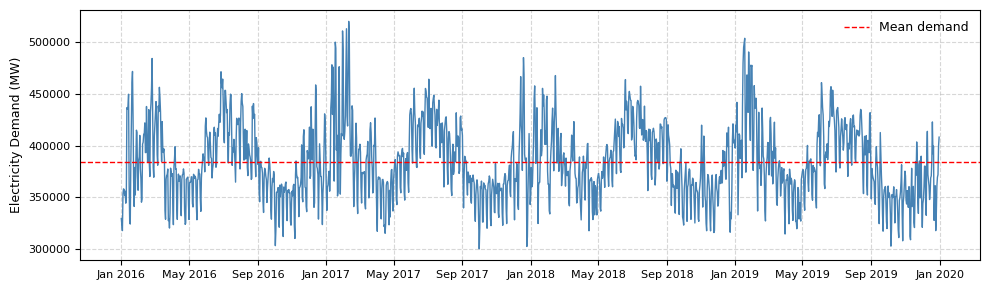

In [ ]:
# 1. Time series plot for response variable: Total 30 min demand (t)
demand_mean = bxp["demand"].mean() 

plt.figure(figsize=(10,3))
plt.plot(bxp["date"], bxp["demand"], color="steelblue", linewidth=1)
plt.axhline(demand_mean, color="red", linestyle="--", linewidth=1, label="Mean demand") #horizontal mean line
plt.ylabel("Electricity Demand (MW)", fontsize=9)
plt.xlabel("")
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=4))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(frameon=False, fontsize=9)
plt.xticks(rotation=0, fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()


### 2.1.2. Climate features

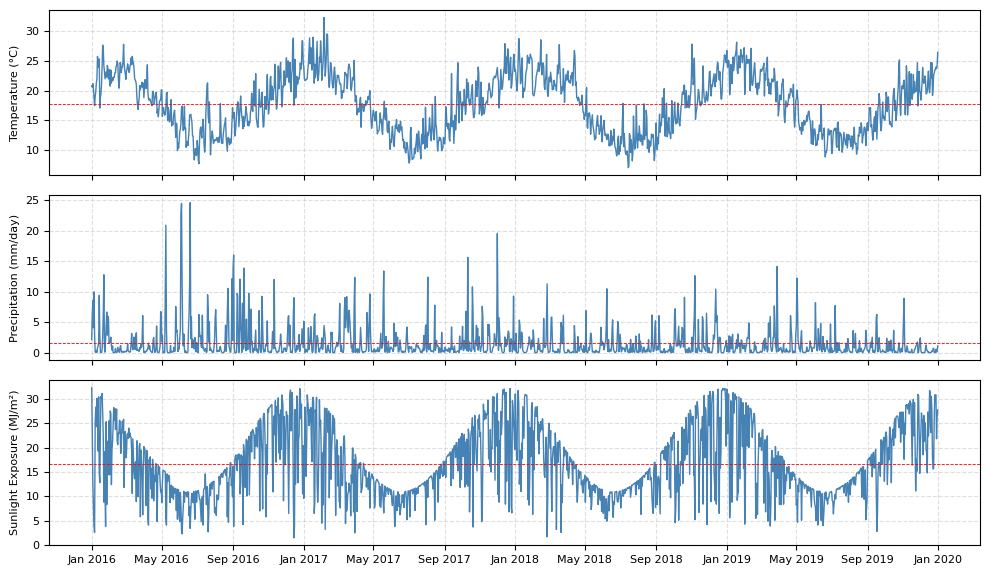

In [76]:
# 2. Time series for continous explanatory variables (Climate features)
vars_to_plot = {"avg_temp": "Temperature (°C)", "precipitation": "Precipitation (mm/day)", "sunlight": "Sunlight Exposure (MJ/m²)"}

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 6), sharex=True)
axes = axes.flatten()
for i, (var, ylabel) in enumerate(vars_to_plot.items()):
    axes[i].plot(bxp["date"], bxp[var], color="steelblue", linewidth=1, label=var)
    mean_val = bxp[var].mean()
    axes[i].axhline(mean_val, color="red", linestyle="--", linewidth=0.6)    
    axes[i].set_ylabel(ylabel, fontsize=8)
    axes[i].grid(True, linestyle="--", alpha=0.4)
    axes[i].tick_params(axis="x", labelrotation=0, labelsize=8)
    axes[i].tick_params(axis="y", labelsize=8)
    #axes[i].legend(frameon=False, fontsize=8, loc="upper right")
axes[-1].xaxis.set_major_locator(mdates.MonthLocator(interval=4))
axes[-1].xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
fig.supxlabel("")
plt.tight_layout()
plt.show()


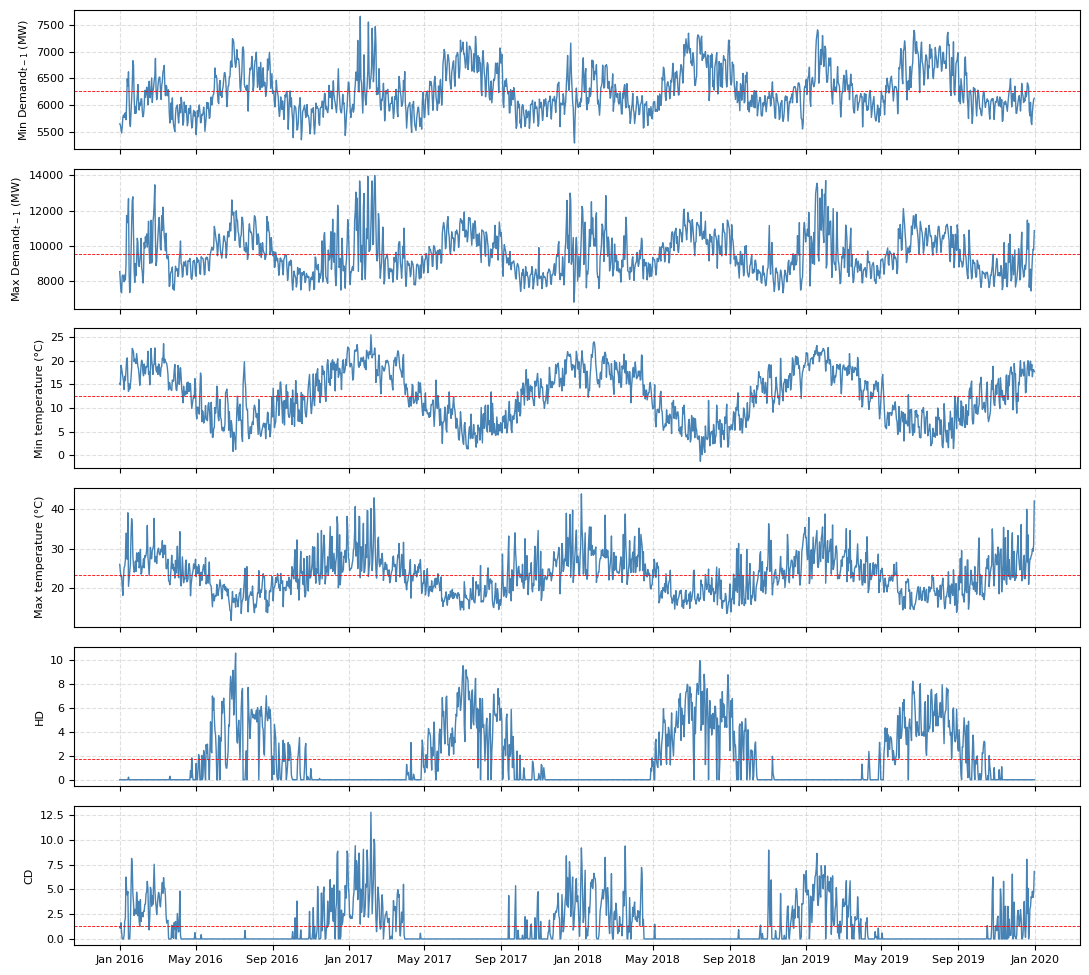

In [9]:
# 3. Time series plot for derived variables 
vars_to_plot = {"lag_min_demand": r"Min Demand$_{t-1}$ (MW)", 
                "lag_max_demand": r"Max Demand$_{t-1}$ (MW)", 
                "min_temp": "Min temperature (°C)", 
                "max_temp": "Max temperature (°C)", 
                "HD": "HD",
                "CD": "CD"}
fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(11, 10), sharex=True)
axes = axes.flatten()
for i, (var, ylabel) in enumerate(vars_to_plot.items()):
    axes[i].plot(bxp["date"], bxp[var], color="steelblue", linewidth=1, label=var)
    mean_val = bxp[var].mean()
    axes[i].axhline(mean_val, color="red", linestyle="--", linewidth=0.6)    
    axes[i].set_ylabel(ylabel, fontsize=8)
    axes[i].grid(True, linestyle="--", alpha=0.4)
    axes[i].tick_params(axis="x", labelrotation=0, labelsize=8)
    axes[i].tick_params(axis="y", labelsize=8)
    #axes[i].legend(frameon=False, fontsize=8, loc="upper right")
axes[-1].xaxis.set_major_locator(mdates.MonthLocator(interval=4))
axes[-1].xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
fig.supxlabel("")
plt.tight_layout()
plt.show()


## 2.2. Boxplots (Categorical vs. Demand)

In [77]:
# Add day and month categorical variables
bxp["day"] = bxp["date"].dt.day_name()
bxp["month"] = bxp["date"].dt.month_name()

# Order of categories
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
month_order = ["January", "February", "March", "April", "May", "June", 
               "July", "August", "September", "October", "November", "December"]

### 2.2.1. Boxplot; Demand by "day of week"

C:\Users\user\AppData\Local\Temp\ipykernel_12868\1015452710.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=bxp, x="day", y="demand", order=day_order,


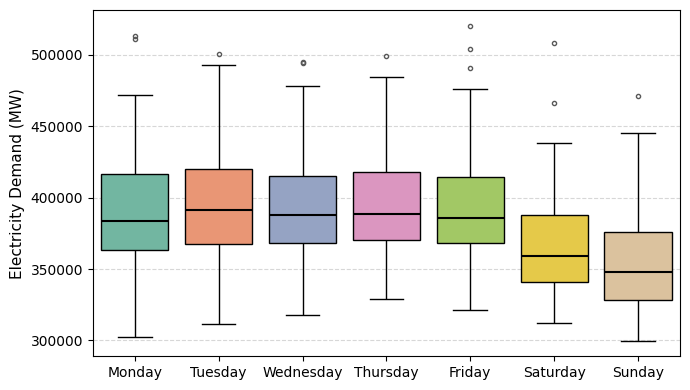

In [78]:
# 1. Electricity demand by "day of week"
plt.figure(figsize=(7,4))
sns.boxplot(data=bxp, x="day", y="demand", order=day_order,
            palette="Set2", fliersize=3, linewidth=1, boxprops=dict(edgecolor="black"),
            whiskerprops=dict(color="black"),
            capprops=dict(color="black"),
            medianprops=dict(color="black", linewidth=1.5))
plt.xlabel("")
plt.ylabel("Electricity Demand (MW)", fontsize=11)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
#NOTE: Two groups; Weekday and Weekend. Weekday (Mon-Fri) similar electricity demand and Weekend (Sat-Sun) similar demand.



### 2.2.2. Boxplots; Electricity by Month

C:\Users\user\AppData\Local\Temp\ipykernel_12868\353564458.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=bxp, x="month", y="demand", order=month_order,


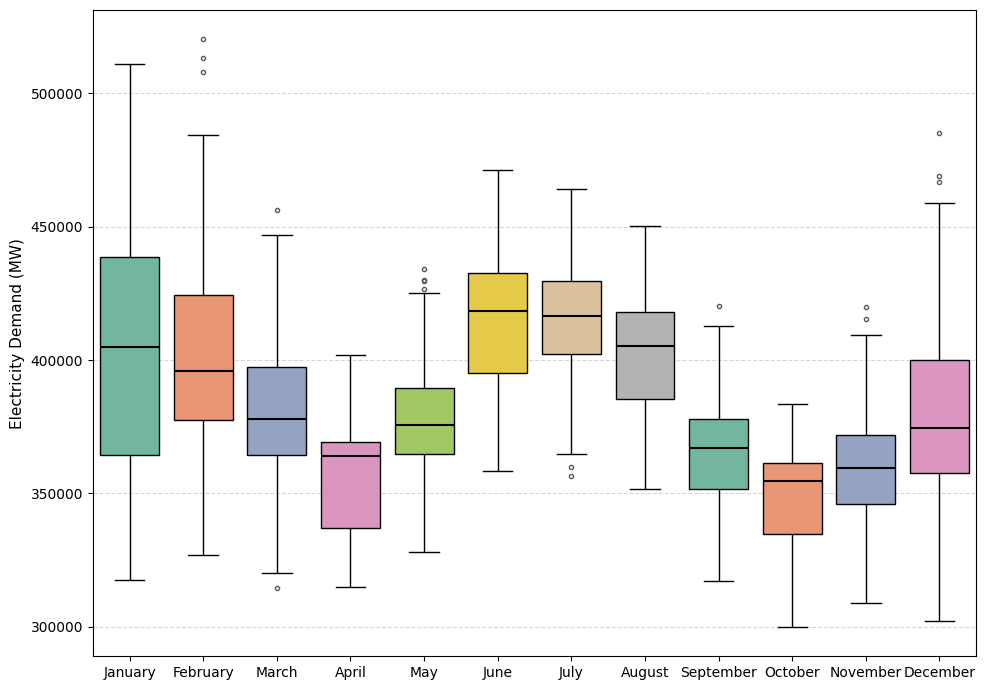

In [79]:
#Electricity demand by Month
plt.figure(figsize=(10,7))
sns.boxplot(data=bxp, x="month", y="demand", order=month_order,
            palette="Set2", fliersize=3, linewidth=1, boxprops=dict(edgecolor="black"),
            whiskerprops=dict(color="black"),
            capprops=dict(color="black"),
            medianprops=dict(color="black", linewidth=1.5))
plt.xlabel("")
plt.ylabel("Electricity Demand (MW)", fontsize=11)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()

#NOTE: Summer months; December, January, February => Similar demand distribution 
# Winter months; March and May similar demand distribution, however, notable lower demand in April
# Autumn months; June, July august => Similar demand distribution 
# Spring months; September, Oct, November => Similar demand distribution 


### 2.2.3. Boxplots; Demand by Quarter indicators

C:\Users\user\AppData\Local\Temp\ipykernel_12868\3304057776.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=bxp, x="quarter", y="demand",


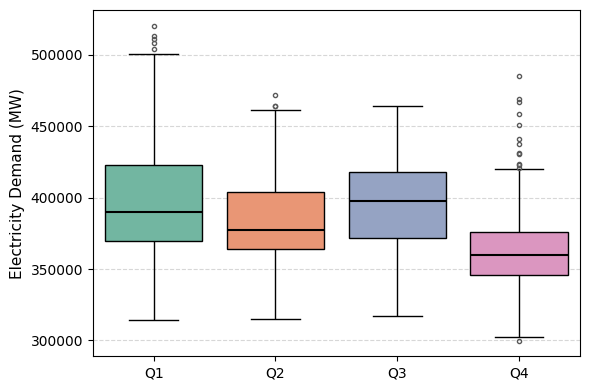

In [80]:
# Electricity demand by Quarter
bxp["quarter"] = bxp["date"].dt.quarter

plt.figure(figsize=(6,4))
sns.boxplot(data=bxp, x="quarter", y="demand", 
            palette="Set2", fliersize=3, linewidth=1, boxprops=dict(edgecolor="black"),
            whiskerprops=dict(color="black"),
            capprops=dict(color="black"),
            medianprops=dict(color="black", linewidth=1.5))
plt.xlabel("")
plt.ylabel("Electricity Demand (MW)", fontsize=11)
plt.xticks(ticks=[0,1,2,3], labels=["Q1", "Q2", "Q3", "Q4"], fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
#NOTE: Q4 has exceptionally lower demand than (Q1, Q2, and Q3)
#NOTE: (Already checked) in regression and ML models, models are not performing well for last quarters of 2019
# So Q1 (for highest variation), and Q3 - Q4 will be added as dummies in final data.

C:\Users\user\AppData\Local\Temp\ipykernel_12868\1330506078.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=bxp, x="season", y="demand", order=["Summer", "Autumn", "Spring", "Winter"],palette="Set2",


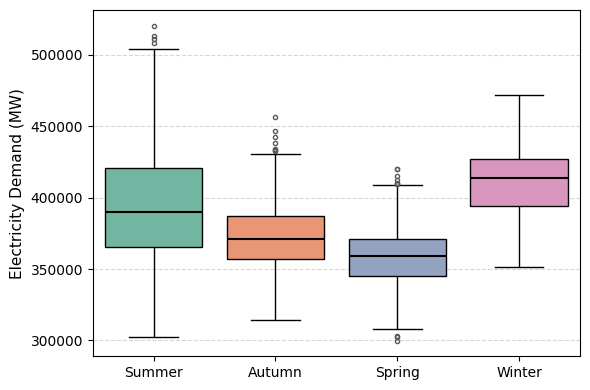

In [100]:
# Add month and season
bxp["month"] = bxp["date"].dt.month

def get_season(month):
    if month in [12, 1, 2]:
        return "Summer"
    elif month in [3, 4, 5]:
        return "Autumn"
    elif month in [6, 7, 8]:
        return "Winter"
    else:
        return "Spring"

bxp["season"] = bxp["month"].apply(get_season)

# boxplot of demand w.r.t. seasons
plt.figure(figsize=(6,4))
sns.boxplot(data=bxp, x="season", y="demand", order=["Summer", "Autumn", "Spring", "Winter"],palette="Set2",     
            fliersize=3, linewidth=1, boxprops=dict(edgecolor="black"), whiskerprops=dict(color="black"),
            capprops=dict(color="black"), medianprops=dict(color="black", linewidth=1.5))
plt.xlabel("")
plt.ylabel("Electricity Demand (MW)", fontsize=11)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
#NOTE: Summer has highest demand (wide variation) but lower median (~ 8k), Winter has comparatively low variation but higher median (~8.5k). 
# Spring and Autumn collectively has similar demand.


## 2.3. Scatterplots (Numeric features vs. Demand)

### 2.3.1. Lagged demand vs. Current demand

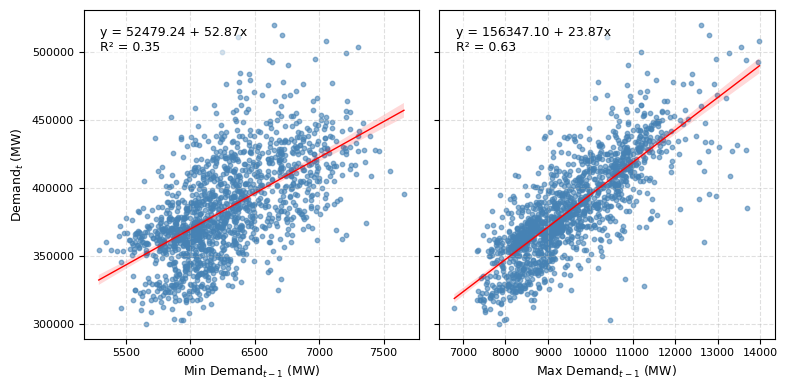

In [ ]:
# Scatter plot of total demand at time t vs. Min_demand (t-1) and Max_demand (t-1)
scatter_pairs = [("lag_min_demand", r"Min Demand$_{t-1}$ (MW)"), ("lag_max_demand", r"Max Demand$_{t-1}$ (MW)")]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), sharey=True)
for i, (xvar, xlabel) in enumerate(scatter_pairs):
    ax = axes[i]
    # Scatter plot with regression line
    sns.regplot(x=bxp[xvar], y=bxp["demand"], scatter_kws={"s": 10, "alpha": 0.6, "color": "steelblue"},  line_kws={"color": "red", "lw": 1}, ax=ax)
    # equation equation and Rsq
    X = sm.add_constant(bxp[xvar])
    y = bxp["demand"]
    model = sm.OLS(y, X).fit()
    intercept, slope = model.params
    r2 = model.rsquared
    #for equation text
    ax.text(0.05, 0.95,  f"y = {intercept:.2f} + {slope:.2f}x\nR² = {r2:.2f}", transform=ax.transAxes, ha="left", va="top", fontsize=9,
            bbox=dict(facecolor="white", alpha=0.6, edgecolor="none"))
    ax.set_xlabel(xlabel, fontsize=9) # Labels
    if i == 0:
        ax.set_ylabel(r"Demand$_{t}$ (MW)", fontsize=9)
    else:
        ax.set_ylabel("")
    ax.grid(True, linestyle="--", alpha=0.4)
    ax.tick_params(axis="both", labelsize=8)

plt.tight_layout()


### 2.3.2. Temperature vs. Current demand

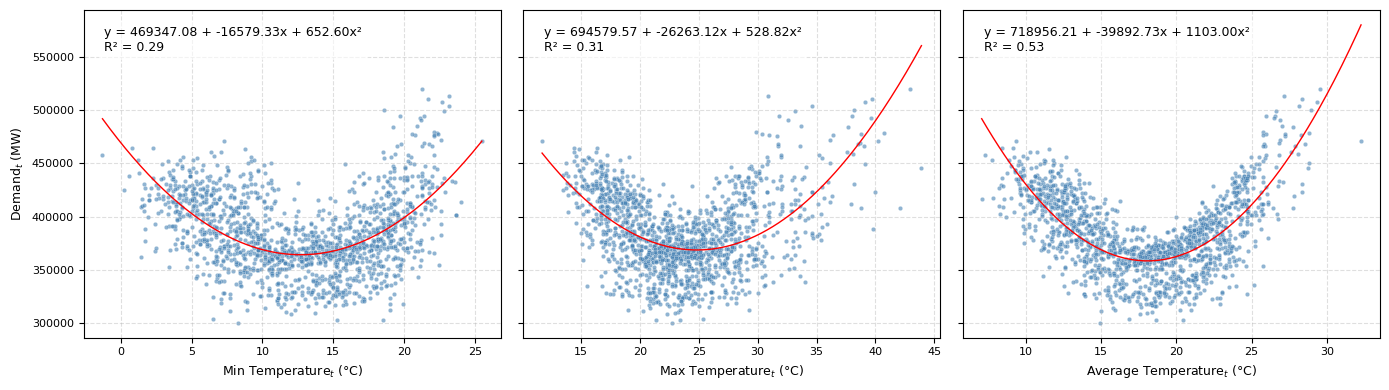

In [ ]:
# Scatter plot of total demand at time t vs.temperature-based variables (t)

temp_vars = [("min_temp", r"Min Temperature$_{t}$ (°C)"),
             ("max_temp", r"Max Temperature$_{t}$ (°C)"),
             ("avg_temp", r"Average Temperature$_{t}$ (°C)")]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14, 4), sharey=True)

for i, (xvar, xlabel) in enumerate(temp_vars):
    ax = axes[i]
    sns.scatterplot(x=bxp[xvar], y=bxp["demand"], 
                    ax=ax, color="steelblue", s=10, alpha=0.6)
    # Polynomial regression fit (degree=2)
    X_poly = np.column_stack((bxp[xvar], bxp[xvar]**2))
    X_poly = sm.add_constant(X_poly)  # add intercept
    y = bxp["demand"]

    model = sm.OLS(y, X_poly).fit()
    intercept, beta1, beta2 = model.params
    r2 = model.rsquared

    # Generate smooth curve
    x_range = np.linspace(bxp[xvar].min(), bxp[xvar].max(), 200)
    y_fit = intercept + beta1 * x_range + beta2 * x_range**2
    ax.plot(x_range, y_fit, color="red", linewidth=1)

    # Equation text
    ax.text(0.05, 0.95,
            f"y = {intercept:.2f} + {beta1:.2f}x + {beta2:.2f}x²\nR² = {r2:.2f}",
            transform=ax.transAxes, ha="left", va="top", fontsize=9,
            bbox=dict(facecolor="white", alpha=0.6, edgecolor="none"))

    # Labels
    ax.set_xlabel(xlabel, fontsize=9)
    if i == 0:
        ax.set_ylabel(r"Demand$_t$ (MW)", fontsize=9)
    else:
        ax.set_ylabel("")
    ax.grid(True, linestyle="--", alpha=0.4)
    ax.tick_params(axis="both", labelsize=8)

plt.tight_layout()

### 2.3.3. Rest of the climate feature vs. Current demand

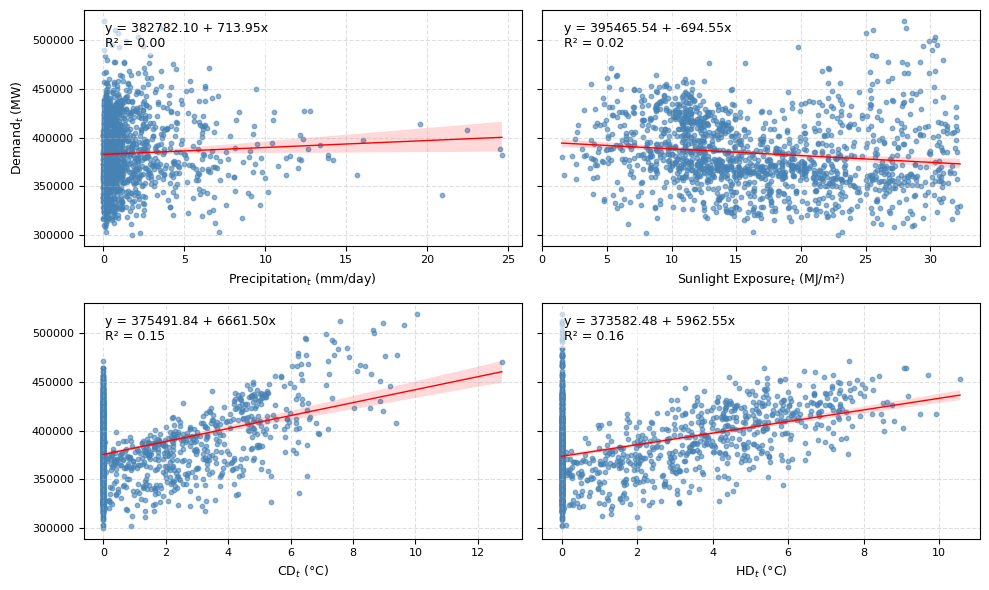

In [83]:
# 3. Scatter plot of demand at time t vs. rest of the climate features
scatter_pairs = [("precipitation", r"Precipitation$_{t}$ (mm/day)"), ("sunlight", r"Sunlight Exposure$_{t}$ (MJ/m²)"), 
                 ("CD", r"CD$_{t}$ (°C)"), ("HD", r"HD$_{t}$ (°C)")]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 6), sharey=True)
axes = axes.flatten()  
for i, (xvar, xlabel) in enumerate(scatter_pairs):
    ax = axes[i]
    # Scatter plot with regression line
    sns.regplot(x=bxp[xvar], y=bxp["demand"], scatter_kws={"s": 10, "alpha": 0.6, "color": "steelblue"}, line_kws={"color": "red", "lw": 1}, ax=ax)
    # Fit regression
    X = sm.add_constant(bxp[xvar])
    y = bxp["demand"]
    model = sm.OLS(y, X).fit()
    intercept, slope = model.params
    r2 = model.rsquared
    # Add regression equation
    ax.text( 0.05, 0.95, f"y = {intercept:.2f} + {slope:.2f}x\nR² = {r2:.2f}", transform=ax.transAxes, ha="left", va="top", fontsize=9,
        bbox=dict(facecolor="white", alpha=0.6, edgecolor="none")) 
    # Labels
    ax.set_xlabel(xlabel, fontsize=9)
    if i == 0:
        ax.set_ylabel(r"Demand$_{t}$ (MW)", fontsize=9)
    else:
        ax.set_ylabel("")
    ax.grid(True, linestyle="--", alpha=0.4)
    ax.tick_params(axis="both", labelsize=8)

plt.tight_layout()


# 3. Feature engineering

## 3.1. Select relevant variables

In [84]:
# Select only relevant variable
# Extract quarter from date
dat2 =dat1.copy()
dat2['quarter'] = dat2['date'].dt.quarter
dat2['is_q1'] = (dat2['quarter'] == 1).astype(int)
dat2['is_q3'] = (dat2['quarter'] == 3).astype(int)
dat2['is_q4'] = (dat2['quarter'] == 4).astype(int)
#dat2["is_bushfire"] = dat2["month"].isin([10, 11, 12, 1, 2, 3]).astype(int)
dat2 = dat2[["date", "demand", "is_weekend", "is_summer", "is_winter", "is_spring", "is_autumn", "is_q1", "is_q3", "is_q4",
             "lag_min_demand", "lag_max_demand", 
             "avg_temp", "min_temp", "max_temp", "HD", "CD", 
             "precipitation", "sunlight"]]
#wildfire_dummy
dat2.head()

,date,demand,is_weekend,is_summer,is_winter,is_spring,is_autumn,is_q1,is_q3,is_q4,lag_min_demand,lag_max_demand,avg_temp,min_temp,max_temp,HD,CD,precipitation,sunlight
0,2016-01-01,329352.88,0,1,0,0,0,1,0,0,5645.67,8529.23,20.783333,15.2,26.0,0.0,1.204082,2.140095,32.3
1,2016-01-02,323133.95,1,1,0,0,0,1,0,0,5631.74,7913.75,20.572917,14.9,24.2,0.0,1.072917,6.496326,23.2
2,2016-01-03,317665.92,1,1,0,0,0,1,0,0,5559.37,7390.04,21.170833,19.0,22.9,0.0,1.630769,8.562486,12.7
3,2016-01-04,353210.40,0,1,0,0,0,1,0,0,5476.66,7328.39,20.277083,18.4,23.1,0.0,0.644444,4.082204,7.6
4,2016-01-05,358082.97,0,1,0,0,0,1,0,0,5589.58,8313.11,18.979167,17.4,20.3,0.0,0.000000,9.977372,3.9


## 3.2. Holidays dummy feature

In [85]:
years = range(2016, 2020)
au_holidays = holidays.Australia(state="NSW", years=years)
au_holidays

# comparison on the same type
dat3 = dat2.copy()
dat3["is_holiday"] = dat3["date"].dt.date.isin(au_holidays).astype(int)
print(dat3["is_holiday"].value_counts())
print(dat3["is_holiday"].value_counts(normalize=True))


is_holiday
0    1415
1      46
Name: count, dtype: int64
is_holiday
0    0.968515
1    0.031485
Name: proportion, dtype: float64


## 3.3. Add polynomial term Temp^2

In [87]:
# add temp^2 as a feature
dat4 = dat3.copy()
dat4["avg_temp2"] = dat4["avg_temp"] ** 2
dat4["min_temp2"] = dat4["min_temp"] ** 2
dat4["max_temp2"] = dat4["max_temp"] ** 2

dat4.head()


,date,demand,is_weekend,is_summer,is_winter,is_spring,is_autumn,is_q1,is_q3,is_q4,...,min_temp,max_temp,HD,CD,precipitation,sunlight,is_holiday,avg_temp2,min_temp2,max_temp2
0,2016-01-01,329352.88,0,1,0,0,0,1,0,0,...,15.2,26.0,0.0,1.204082,2.140095,32.3,1,431.946944,231.04,676.00
1,2016-01-02,323133.95,1,1,0,0,0,1,0,0,...,14.9,24.2,0.0,1.072917,6.496326,23.2,0,423.244900,222.01,585.64
2,2016-01-03,317665.92,1,1,0,0,0,1,0,0,...,19.0,22.9,0.0,1.630769,8.562486,12.7,0,448.204184,361.00,524.41
3,2016-01-04,353210.40,0,1,0,0,0,1,0,0,...,18.4,23.1,0.0,0.644444,4.082204,7.6,0,411.160108,338.56,533.61
4,2016-01-05,358082.97,0,1,0,0,0,1,0,0,...,17.4,20.3,0.0,0.000000,9.977372,3.9,0,360.208767,302.76,412.09


# 4. Train-test splitting

In [88]:
reg_dat = dat4
print(reg_dat.head())

# Split into train (2016–2018) and test (2019)
train = reg_dat[(reg_dat["date"] >= "2016-01-01") & (reg_dat["date"] <= "2018-12-31")]
test = reg_dat[(reg_dat["date"] >= "2019-01-01") & (reg_dat["date"] <= "2019-12-31")]
train = train.set_index("date")
test = test.set_index("date")
print("Train shape:", train.shape)
print("Test shape:", test.shape)

# list of predictors and target
features = ["is_weekend", "is_holiday", "is_summer", "is_winter", "is_spring", "is_autumn", "is_q1", "is_q3", "is_q4", 
            "lag_min_demand", "lag_max_demand", "avg_temp", "avg_temp2",
              "min_temp", "min_temp2", "max_temp", "max_temp2","CD", "HD",
                "precipitation", "sunlight"]
target = "demand"

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

        date     demand  is_weekend  is_summer  is_winter  is_spring  \
0 2016-01-01  329352.88           0          1          0          0   
1 2016-01-02  323133.95           1          1          0          0   
2 2016-01-03  317665.92           1          1          0          0   
3 2016-01-04  353210.40           0          1          0          0   
4 2016-01-05  358082.97           0          1          0          0   

   is_autumn  is_q1  is_q3  is_q4  ...  min_temp  max_temp   HD        CD  \
0          0      1      0      0  ...      15.2      26.0  0.0  1.204082   
1          0      1      0      0  ...      14.9      24.2  0.0  1.072917   
2          0      1      0      0  ...      19.0      22.9  0.0  1.630769   
3          0      1      0      0  ...      18.4      23.1  0.0  0.644444   
4          0      1      0      0  ...      17.4      20.3  0.0  0.000000   

   precipitation  sunlight  is_holiday   avg_temp2  min_temp2  max_temp2  
0       2.140095      32.3   

# 5. Regression analysis

## 5.1. Baseline regression model

In [104]:
# Baseline regression model
mod_base = smf.ols("demand ~ is_weekend + is_winter + is_spring + is_holiday + is_q1 + is_q4 +" \
" lag_min_demand+  lag_max_demand + avg_temp + avg_temp2+ " \
" min_temp + min_temp2 + max_temp + max_temp2 + CD + HD + sunlight + " \
"is_summer:avg_temp + is_q1:avg_temp + is_q3:sunlight + is_q4:avg_temp ", 
               data=train).fit()
print(mod_base.summary())

"is_summer:sunlight+ is_weekend:lag_min_demand + is_summer:lag_max_demand + is_summer:HD",

# Get predictions
y_pred_tr_mod_base = mod_base.predict(train)
y_pred_ts_mod_base = mod_base.predict(test)

print(performance(y_train, y_pred_tr_mod_base, y_test, y_pred_ts_mod_base, model_name="Regression model"))
#plot_train_prediction(y_train, y_pred_tr_mod_base, title='Forecast on train series')
#plot_test_prediction(y_test, y_pred_ts_mod_base, title='Forecast on test series')

                            OLS Regression Results                            
Dep. Variable:                 demand   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                     700.1
Date:                Thu, 02 Oct 2025   Prob (F-statistic):               0.00
Time:                        19:35:47   Log-Likelihood:                -11569.
No. Observations:                1096   AIC:                         2.318e+04
Df Residuals:                    1074   BIC:                         2.329e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            4.02e+05   1.79

In [ ]:
#NOTE: Forecasting going wrong in last months of 2019 (e.g., more gap between actual vs forecast demand)
#Need to look into it, the factor which is causing this difference. It is specific to 2019 since model is fitting well in 2016-2018.

### 5.1.1. Regression plots

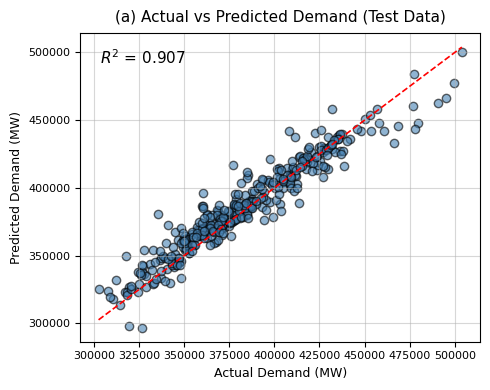

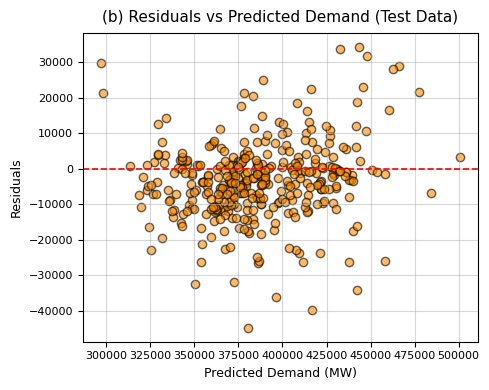

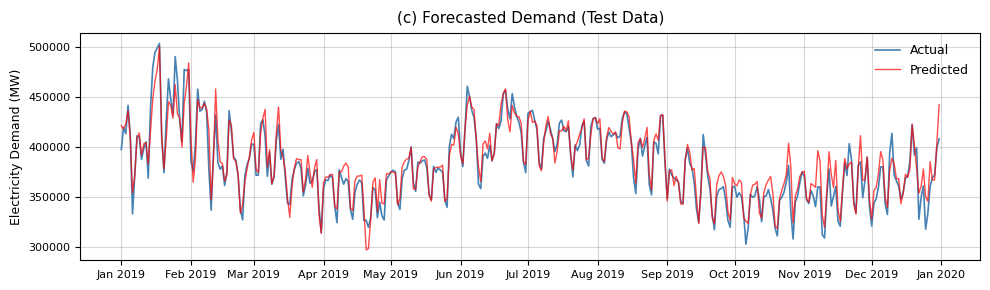

In [105]:
# plots
plot_actual_vs_predicted(y_test, y_pred_ts_mod_base, title="(a) Actual vs Predicted Demand (Test Data)")
plot_residuals(y_test, y_pred_ts_mod_base, title="(b) Residuals vs Predicted Demand (Test Data)")
plot_test_prediction(y_test, y_pred_ts_mod_base, title='(c) Forecasted Demand (Test Data)')


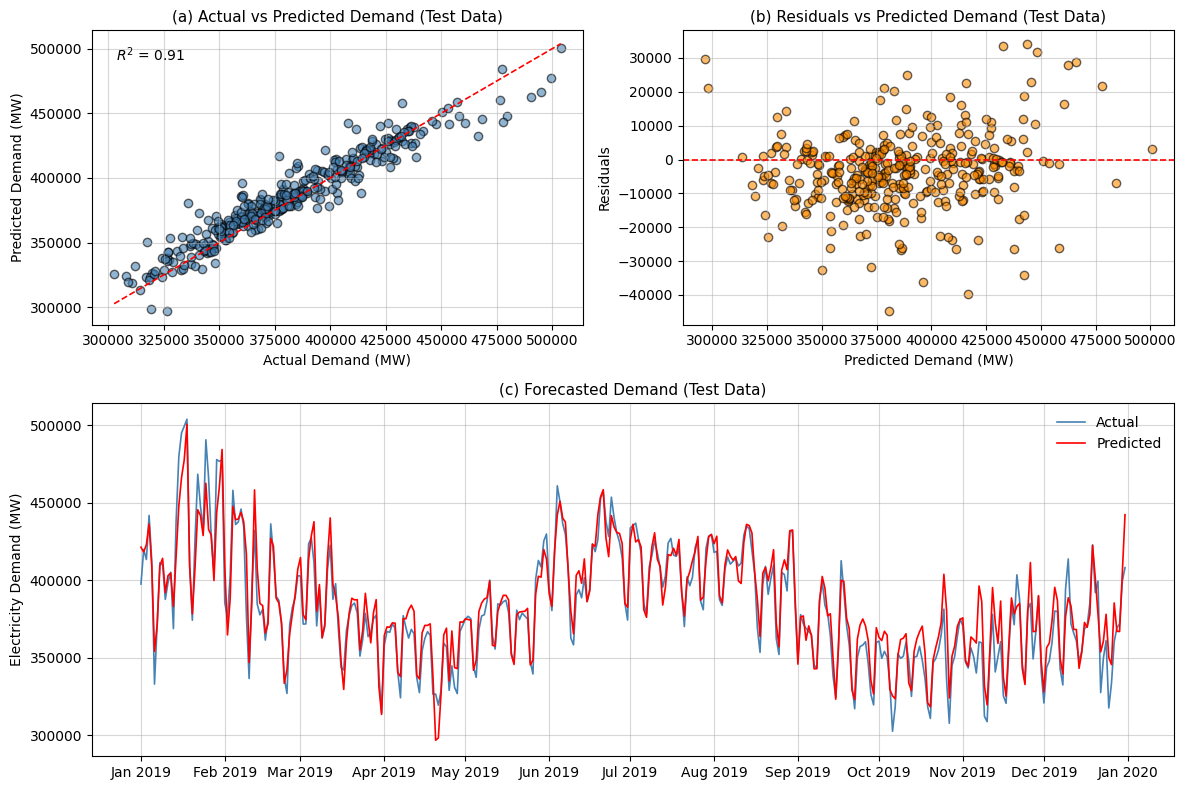

In [107]:
from sklearn.metrics import r2_score
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1.2])  

# (a) Actual vs Predicted
ax1 = fig.add_subplot(gs[0, 0])
r2 = r2_score(y_test, y_pred_ts_mod_base)
ax1.scatter(y_test, y_pred_ts_mod_base, alpha=0.6, color="steelblue", edgecolor="k")
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         color="red", linestyle="--", linewidth=1.2)
ax1.set_xlabel("Actual Demand (MW)", fontsize=10)
ax1.set_ylabel("Predicted Demand (MW)", fontsize=10)
ax1.set_title("(a) Actual vs Predicted Demand (Test Data)", loc="center", fontsize=11)
ax1.text(0.05, 0.95, f"$R^2$ = {r2:.2f}", transform=ax1.transAxes,
         fontsize=10, verticalalignment="top", horizontalalignment="left")
ax1.grid(True, alpha=0.5)

# (b) Residuals vs Predicted
ax2 = fig.add_subplot(gs[0, 1])
residuals = y_test - y_pred_ts_mod_base
ax2.scatter(y_pred_ts_mod_base, residuals, alpha=0.6, color="darkorange", edgecolor="k")
ax2.axhline(0, color="red", linestyle="--", linewidth=1.2)
ax2.set_xlabel("Predicted Demand (MW)", fontsize=10)
ax2.set_ylabel("Residuals", fontsize=10)
ax2.set_title("(b) Residuals vs Predicted Demand (Test Data)", loc="center", fontsize=11)
ax2.grid(True, alpha=0.5)

# (c) Forecasted Demand spanning bottom row
ax3 = fig.add_subplot(gs[1, :])  # spans across both columns
ax3.plot(y_test.index, y_test, color="steelblue", linewidth=1.2, label="Actual")
ax3.plot(y_test.index, y_pred_ts_mod_base, color="red", linewidth=1.2, label="Predicted")
ax3.set_ylabel("Electricity Demand (MW)", fontsize=10)
ax3.set_xlabel("")
ax3.set_title("(c) Forecasted Demand (Test Data)", loc="center", fontsize=11)
ax3.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax3.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
ax3.grid(True, alpha=0.5)
ax3.legend(frameon=False, fontsize=10)

plt.tight_layout()


# 6. Machine learning models

In [ ]:
"demand ~ is_weekend + is_summer+ is_winter + is_holiday + is_q1 + is_q3 + is_q4" \
" lag_min_demand+  lag_max_demand + avg_temp + avg_temp2+ " \
" min_temp + min_temp2 + max_temp + max_temp2 + CD + HD + sunlight + " \
"is_summer:avg_temp + is_q1:avg_temp + is_q1:sunlight + is_q4:avg_temp "

ml_train = train.copy()
ml_test = test.copy()

# Add interaction features for machine learning models
ml_train["is_summer_avg_temp"] = ml_train["is_summer"] * ml_train["avg_temp"]
ml_train["is_q1_avg_temp"] = ml_train["is_q1"] * ml_train["avg_temp"]
ml_train["is_q3_sunlight"] = ml_train["is_q3"] * ml_train["sunlight"]
ml_train["is_q4_avg_temp"] = ml_train["is_q4"] * ml_train["avg_temp"]
ml_test["is_summer_avg_temp"] = ml_test["is_summer"] * ml_test["avg_temp"]
ml_test["is_q1_avg_temp"] = ml_test["is_q1"] * ml_test["avg_temp"]
ml_test["is_q3_sunlight"] = ml_test["is_q3"] * ml_test["sunlight"]
ml_test["is_q4_avg_temp"] = ml_test["is_q4"] * ml_test["avg_temp"]

# Updated features
ml_features = ["is_weekend", "is_summer", "is_winter", "is_spring", "is_holiday", "is_q1", "is_q3", "is_q4", 
               "lag_min_demand", "lag_max_demand", "avg_temp2",
               "min_temp2",  "max_temp2", "CD", "HD", "sunlight"]
#"avg_temp", "min_temp", "max_temp",, "precipitation", "is_summer_avg_temp", "is_q1_avg_temp", "is_q1_sunlight", "is_q4_avg_temp"
Xtr = ml_train[ml_features]
ytr = ml_train["demand"]
Xts = ml_test[ml_features]
yts = ml_test["demand"]


## 6.1. Gradianet boosting regression

               Model Dataset       MSE    RMSE     MAE  MAPE (%)    R²
0  Gradient Boosting   Train  21064.95  145.14  107.36      1.34  0.96
1  Gradient Boosting    Test  62338.60  249.68  180.04      2.29  0.90


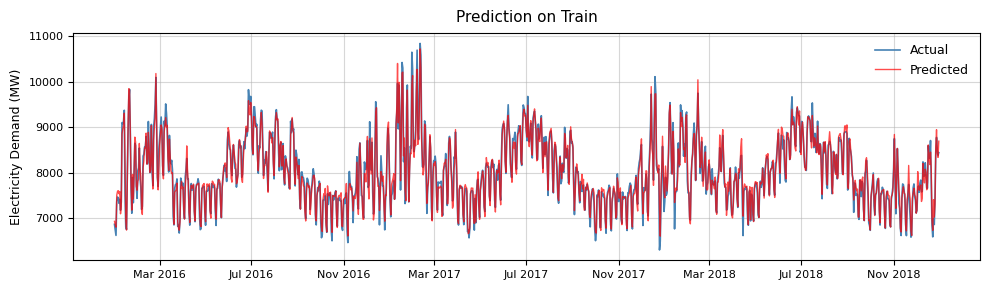

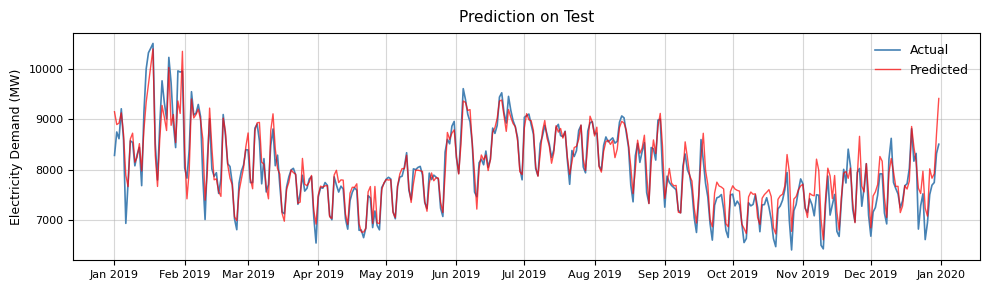

In [49]:
# Train Gradient Boosting Regressor
gbr0 = GradientBoostingRegressor(n_estimators=500,  # number of boosting stages
                                 learning_rate=0.01,     # shrinkage, smaller = less overfitting
                                 max_depth=4,  
                                 min_samples_split=10,   # prevent small splits
                                 min_samples_leaf=5, 
                                 subsample=0.7, 
                                 random_state=42)
gbr0.fit(Xtr, ytr)

# Predictions
ytr_gbr0 = gbr0.predict(Xtr)
yts_gbr0 = gbr0.predict(Xts)

# performance
print(performance(ytr, ytr_gbr0, yts, yts_gbr0, model_name="Gradient Boosting"))
plot_train_prediction(y_train, ytr_gbr0, title='Prediction on Train')
plot_test_prediction(y_test, yts_gbr0, title='Prediction on Test')


## 6.2. LightGBM

Training until validation scores don't improve for 300 rounds
[100]	train's rmse: 405.037	valid's rmse: 461.049
[200]	train's rmse: 284.839	valid's rmse: 347.738
[300]	train's rmse: 242.128	valid's rmse: 307.712
[400]	train's rmse: 223.297	valid's rmse: 290.961
[500]	train's rmse: 212.31	valid's rmse: 282.23
[600]	train's rmse: 204.076	valid's rmse: 276.406
[700]	train's rmse: 196.704	valid's rmse: 272.473
[800]	train's rmse: 190.97	valid's rmse: 269.24
[900]	train's rmse: 185.921	valid's rmse: 267.425
[1000]	train's rmse: 181.274	valid's rmse: 265.88
[1100]	train's rmse: 177.482	valid's rmse: 265.384
[1200]	train's rmse: 173.875	valid's rmse: 264.239
[1300]	train's rmse: 170.116	valid's rmse: 263.878
[1400]	train's rmse: 166.871	valid's rmse: 263.203
[1500]	train's rmse: 163.877	valid's rmse: 263.671
[1600]	train's rmse: 161.044	valid's rmse: 263.628
[1700]	train's rmse: 158.231	valid's rmse: 262.634
[1800]	train's rmse: 155.726	valid's rmse: 262.366
[1900]	train's rmse: 153.53	valid'

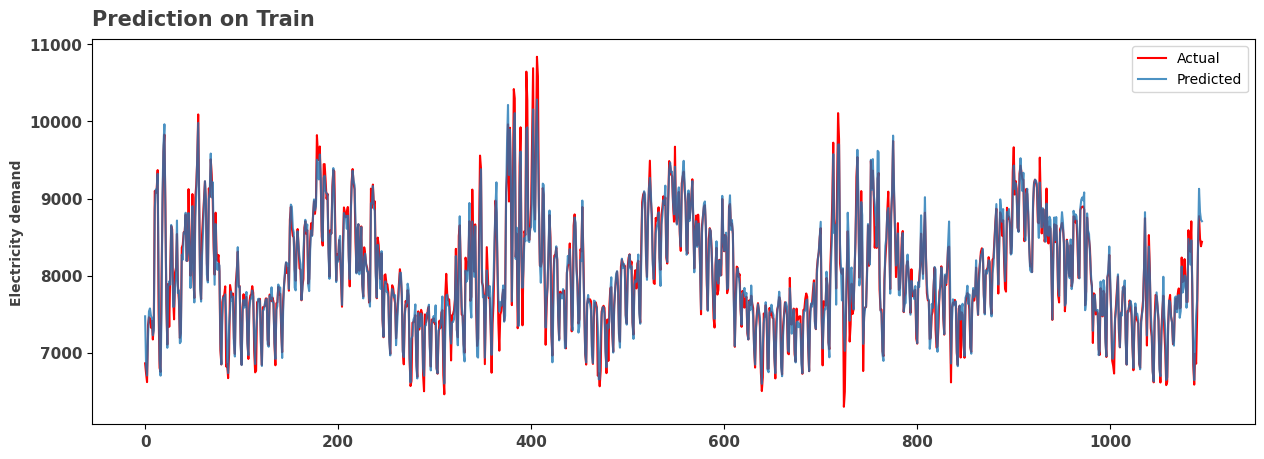

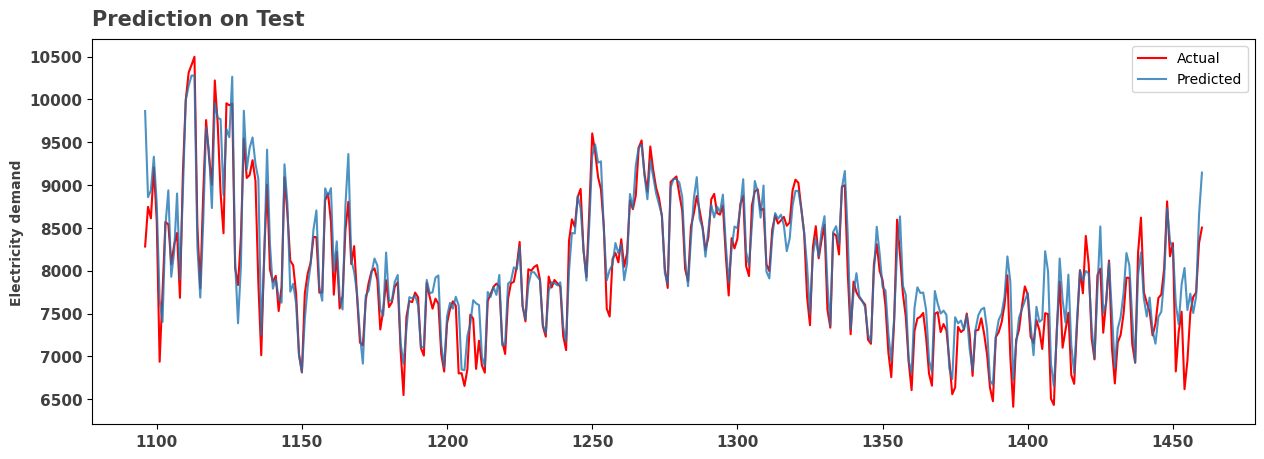

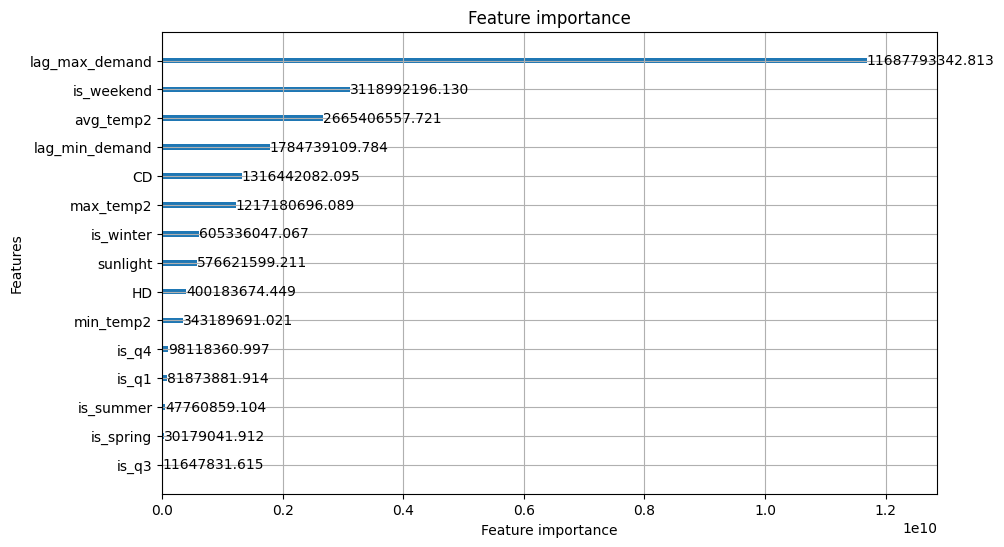

In [ ]:
# LightGBM dataset
train_set = lgb.Dataset(Xtr, label=ytr)
valid_set = lgb.Dataset(Xts, label=yts, reference=train_set)
train_set

# parameters for LightGBM
params_lgb0 = {"objective": "regression",
               "boosting_type": "gbdt",   # by-default;Gradient Boosting Decision Tree
               "metric": "rmse",
               "num_leaves": 30, 
               "max_depth": 10,          
               "learning_rate": 0.01, 
               "feature_fraction": 0.8, # randomly select features
               "bagging_fraction": 0.8, # bootstrap data
               "bagging_freq": 5,   # frequency for bagging
               "min_data_in_leaf": 50,  
               "lambda_l1": 0.2,  # L1 regularization
               "lambda_l2": 0.1,  # L2 regularization
               "verbosity": -1, "seed": 42}

# Train model with early stopping
lgb0 = lgb.train(params_lgb0, train_set, num_boost_round=2000, 
                 valid_sets=[train_set, valid_set],
                 valid_names=["train", "valid"],
                 callbacks=[early_stopping(stopping_rounds=300), log_evaluation(100)])

# Predictions
ytr_lgbo0 = lgb0.predict(Xtr, num_iteration=lgb0.best_iteration)
yts_lgb0 = lgb0.predict(Xts, num_iteration=lgb0.best_iteration)

# Evaluation
print(performance(ytr, ytr_lgbo0, yts, yts_lgb0, model_name="LightGBM"))
plot_train_prediction(ytr, ytr_lgbo0, title='Prediction on Train')
plot_test_prediction(yts, yts_lgb0, title='Prediction on Test')

# Feature importance
lgb.plot_importance(lgb0, max_num_features=20, importance_type="gain", figsize=(10,6))
plt.show()


## 6.3. CatBoost

0:	learn: 734.6522262	test: 774.1190131	best: 774.1190131 (0)	total: 187ms	remaining: 6m 13s
100:	learn: 447.9653924	test: 493.8551516	best: 493.8551516 (100)	total: 330ms	remaining: 6.2s
200:	learn: 330.1147762	test: 383.2273133	best: 383.2273133 (200)	total: 531ms	remaining: 4.75s
300:	learn: 270.5684518	test: 330.2913530	best: 330.2913530 (300)	total: 692ms	remaining: 3.91s
400:	learn: 237.8335566	test: 299.0918236	best: 299.0918236 (400)	total: 846ms	remaining: 3.38s
500:	learn: 219.9635893	test: 282.9287996	best: 282.9287996 (500)	total: 1.02s	remaining: 3.04s
600:	learn: 207.3567798	test: 272.5219349	best: 272.5219349 (600)	total: 1.19s	remaining: 2.77s
700:	learn: 197.8287730	test: 264.6099284	best: 264.6099284 (700)	total: 1.35s	remaining: 2.51s
800:	learn: 190.2846428	test: 258.7467873	best: 258.7467873 (800)	total: 1.5s	remaining: 2.24s
900:	learn: 184.3408359	test: 254.4614638	best: 254.4614638 (900)	total: 1.65s	remaining: 2.01s
1000:	learn: 179.1027202	test: 250.6577276	be

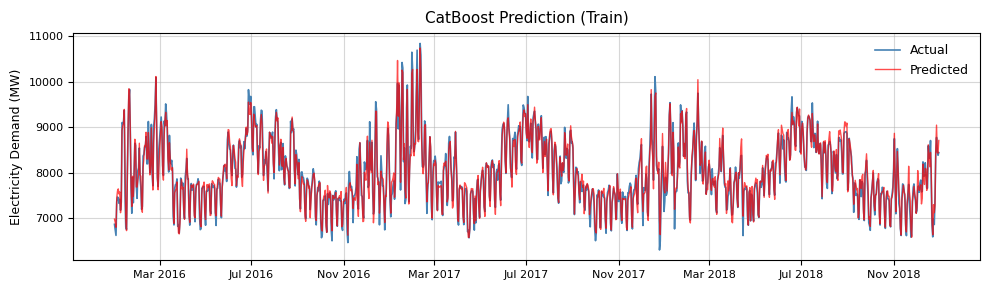

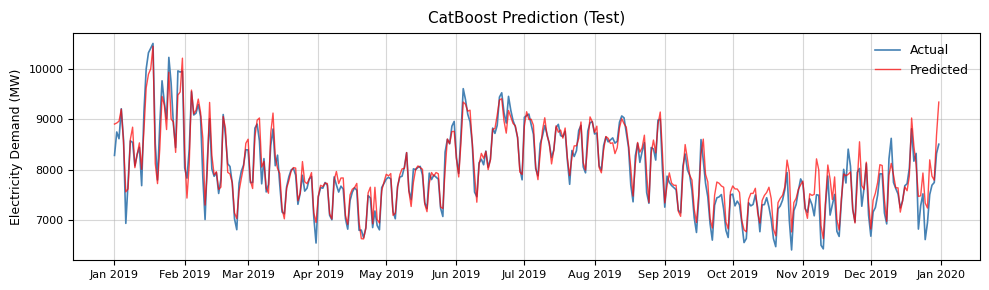

In [50]:
# Define CatBoost Regressor
cat0 = CatBoostRegressor(iterations=2000, # maximum no. of trees
                         learning_rate=0.01, 
                         depth=4, # tree depth
                         l2_leaf_reg=10,  # L2 regularization
                         bootstrap_type='Bernoulli',
                         subsample=0.7,
                         early_stopping_rounds=100,
                         random_seed=42, verbose=100)

# Fit model
cat0.fit(Xtr, ytr, eval_set=(Xts, yts),
    use_best_model=True)

# Predictions
ytr_cat0 = cat0.predict(Xtr)
yts_cat0 = cat0.predict(Xts)

# Performance
print(performance(ytr, ytr_cat0, yts, yts_cat0, model_name="CatBoost"))
plot_train_prediction(ytr, ytr_cat0, title="CatBoost Prediction (Train)")
plot_test_prediction(yts, yts_cat0, title="CatBoost Prediction (Test)")


### 6.3.1. Hypertuned Catboost
First extracting top 10 features (based on their importance) from CatBoost model. These 10 features will be further used to apply CatBoost again with paramters tuned.

In [340]:
#plt.plot(cat0.feature_importances_)
imp_cat0= cat0.get_feature_importance(prettified=True).iloc[0:10,]
imp_cat0


,Feature Id,Importances
0,lag_max_demand,33.313691
1,is_weekend,21.113291
2,avg_temp2,11.660867
3,CD,9.032007
4,max_temp2,6.551623
5,sunlight,3.063626
6,lag_min_demand,3.046366
7,is_holiday,2.875587
8,HD,2.419590
9,is_winter,2.139121


In [331]:
# Updated features
ml_features0 = imp_cat0['Feature Id']
#"avg_temp", "min_temp", "max_temp",, "precipitation", "is_summer_avg_temp", "is_q1_avg_temp", "is_q1_sunlight", "is_q4_avg_temp"
Xtr0 = ml_train[ml_features0]
ytr0 = ml_train["demand"]
Xts0 = ml_test[ml_features0]
yts0 = ml_test["demand"]

In [332]:
# Objective function for Optuna
def catboost_objective(trial):
    params = {"iterations": 2000,
              "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.05),
              "depth": trial.suggest_int("depth", 4, 8),
              "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1, 10),
              "bootstrap_type": "Bernoulli",
              "subsample": trial.suggest_float("subsample", 0.7, 0.9),
              "random_seed": 42, "early_stopping_rounds": 100, "verbose": 0}
    model = CatBoostRegressor(**params)
    model.fit(Xtr0, ytr0, eval_set=(Xts0, yts0), use_best_model=True)
    y_pred = model.predict(Xts0)
    
    # Objective: minimize RMSE on test set
    rmse = np.sqrt(mean_squared_error(yts0, y_pred))
    return rmse

# Optuna study
study_cat1 = optuna.create_study(direction="minimize")
study_cat1.optimize(catboost_objective, n_trials=50)  #increase trials for better tuning

[I 2025-09-19 05:28:23,576] A new study created in memory with name: no-name-eba00ea8-5e80-451b-9b43-31415d4fbf2c
[I 2025-09-19 05:28:30,686] Trial 0 finished with value: 223.78695756998974 and parameters: {'learning_rate': 0.034248334027351196, 'depth': 7, 'l2_leaf_reg': 5.6102618151702295, 'subsample': 0.784298698054238}. Best is trial 0 with value: 223.78695756998974.
[I 2025-09-19 05:28:34,951] Trial 1 finished with value: 224.37709930539415 and parameters: {'learning_rate': 0.04045113640738248, 'depth': 6, 'l2_leaf_reg': 4.152356493798351, 'subsample': 0.8554900882363957}. Best is trial 0 with value: 223.78695756998974.
[I 2025-09-19 05:28:37,867] Trial 2 finished with value: 222.245280605048 and parameters: {'learning_rate': 0.04764024806681657, 'depth': 4, 'l2_leaf_reg': 4.218363212133715, 'subsample': 0.8444970607686079}. Best is trial 2 with value: 222.245280605048.
[I 2025-09-19 05:28:47,259] Trial 3 finished with value: 226.17392155383754 and parameters: {'learning_rate': 0.

Best Parameters: {'learning_rate': 0.04726604052558224, 'depth': 5, 'l2_leaf_reg': 6.085712920563729, 'subsample': 0.7406826915248228}
0:	learn: 716.5761951	test: 756.5657533	best: 756.5657533 (0)	total: 2.5ms	remaining: 5s
100:	learn: 206.1417285	test: 280.4198268	best: 280.4198268 (100)	total: 164ms	remaining: 3.08s
200:	learn: 172.7285138	test: 256.8111045	best: 256.8111045 (200)	total: 311ms	remaining: 2.78s
300:	learn: 153.8901100	test: 244.7755222	best: 244.7755222 (300)	total: 455ms	remaining: 2.57s
400:	learn: 140.9117526	test: 237.4488062	best: 237.4488062 (400)	total: 627ms	remaining: 2.5s
500:	learn: 131.4447267	test: 233.3889615	best: 233.3889615 (500)	total: 807ms	remaining: 2.42s
600:	learn: 123.8189616	test: 230.9099202	best: 230.9099202 (600)	total: 978ms	remaining: 2.28s
700:	learn: 116.9240239	test: 228.5412798	best: 228.5223144 (694)	total: 1.16s	remaining: 2.15s
800:	learn: 110.8866001	test: 225.9502841	best: 225.9502841 (800)	total: 1.33s	remaining: 1.99s
900:	lear

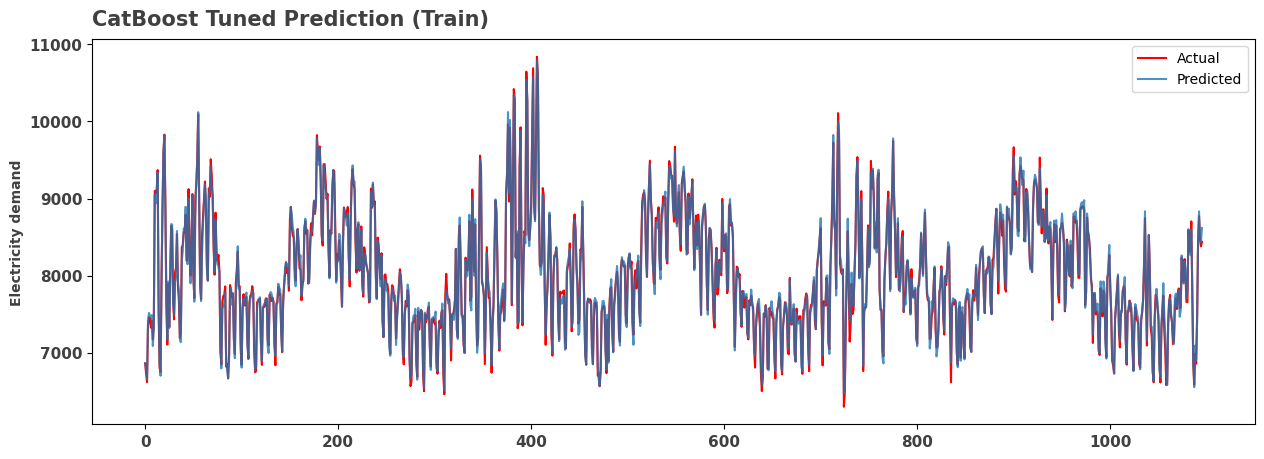

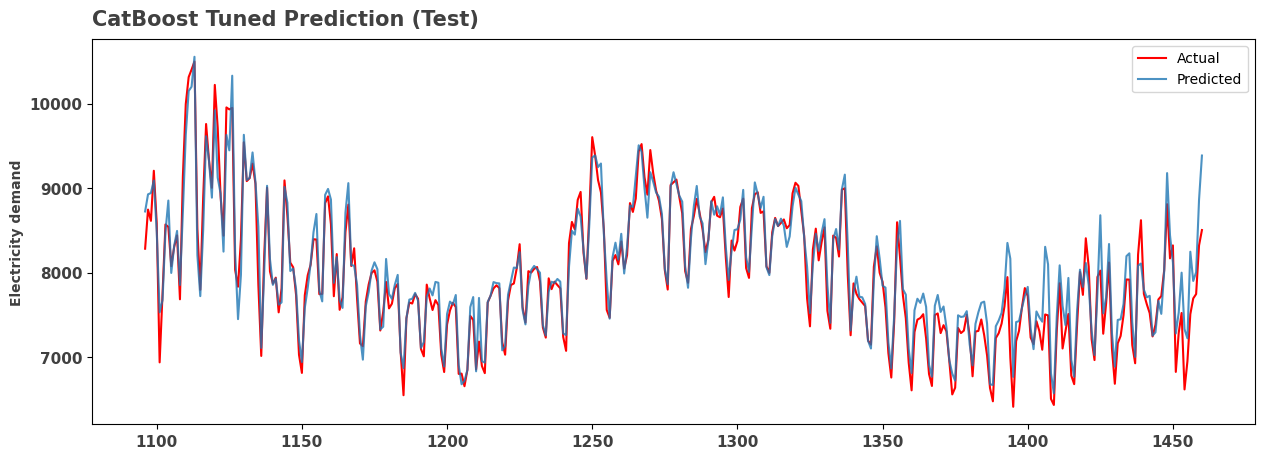

In [333]:
# Best parameters
best_params_cat1 = study_cat1.best_params
print("Best Parameters:", best_params_cat1)

# Train final model with best parameters
cat1 = CatBoostRegressor(iterations=2000,
                         learning_rate=best_params_cat1["learning_rate"],
                         depth=best_params_cat1["depth"],
                         l2_leaf_reg=best_params_cat1["l2_leaf_reg"],
                         bootstrap_type="Bernoulli",
                         subsample=best_params_cat1["subsample"],
                         random_seed=42,
                         early_stopping_rounds=100, verbose=100)
cat1.fit(Xtr0, ytr0, eval_set=(Xts0, yts0), use_best_model=True)

# Predictions
ytr_cat1 = cat1.predict(Xtr0)
yts_cat1 = cat1.predict(Xts0)

# Performance
print(performance(ytr, ytr_cat1, yts, yts_cat1, model_name="CatBoost Tuned"))
plot_prediction(ytr, ytr_cat1, title="CatBoost Tuned Prediction (Train)")
plot_prediction(yts, yts_cat1, title="CatBoost Tuned Prediction (Test)")
#overfitting on train data


## 6.4. XGBoost

       Model Dataset       MSE    RMSE     MAE  MAPE (%)    R²
0  Basic XGB   Train  21843.29  147.79  110.10      1.38  0.96
1  Basic XGB    Test  61604.86  248.20  177.85      2.26  0.90


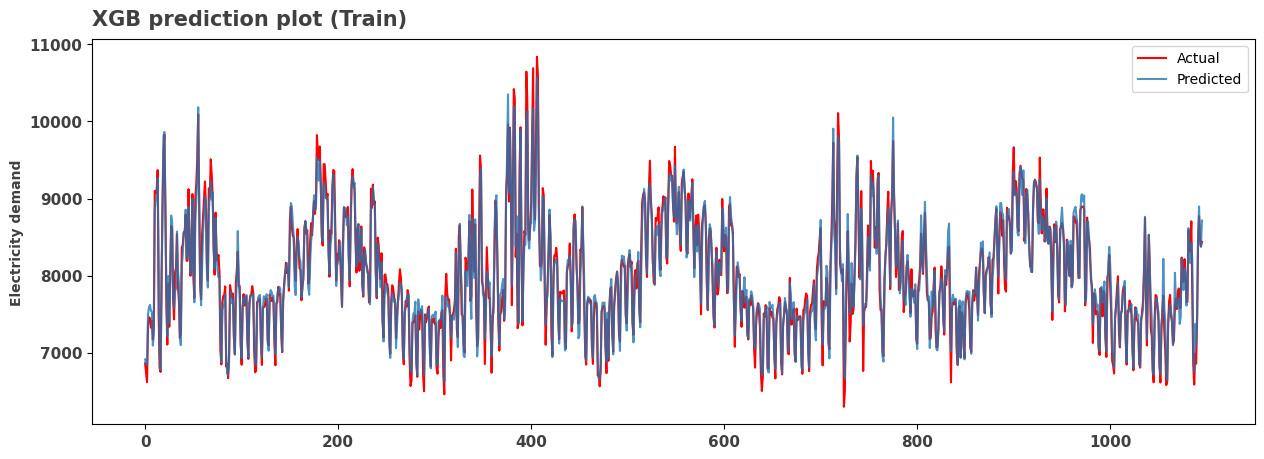

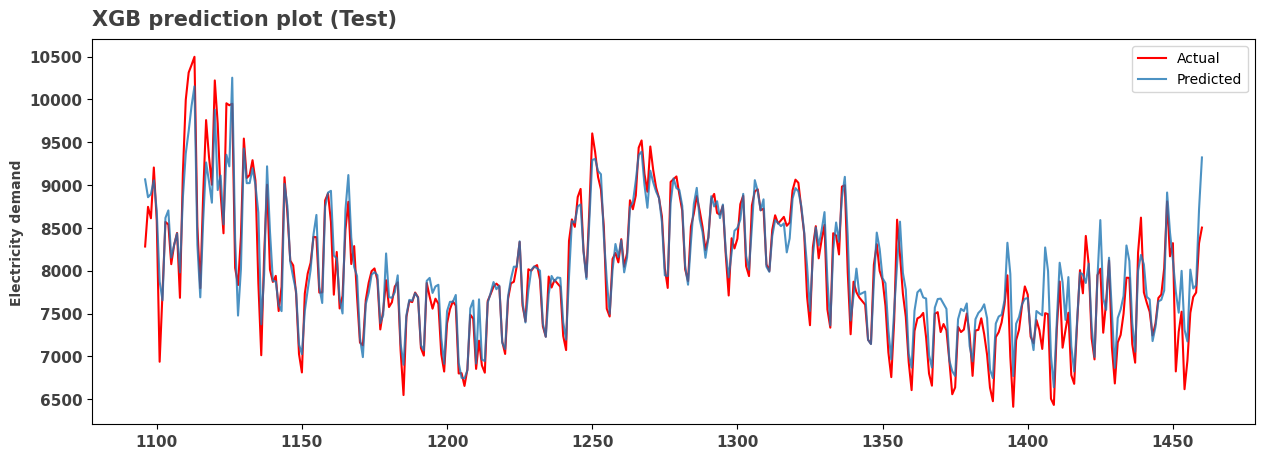

In [19]:
xgb0 = XGBRegressor(n_estimators=500, learning_rate=0.01, 
                    max_depth=4, subsample=0.7, colsample_bytree=0.7,  random_state=42)
xgb0.fit(Xtr, ytr)

ytr_xgb0 = xgb0.predict(Xtr)
yts_xgb0 = xgb0.predict(Xts)

print(performance(y_train, ytr_xgb0,y_test, yts_xgb0, model_name= "Basic XGB"))
plot_prediction(y_train, ytr_xgb0, title="XGB prediction plot (Train)")
plot_prediction(y_test, yts_xgb0, title="XGB prediction plot (Test)")